# Distribution analysis of clusters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
# from vae import VAE
from dataloader import UTKFaceDataset
import seaborn as sns
import pandas as pd
from ae import AutoEncoderNet
from torchvision.utils import make_grid
from sklearn import metrics
from sklearn.cluster import KMeans
from matplotlib import gridspec
from sklearn import metrics
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Model and data

In [2]:
BATCH_SIZE = 64
DEVICE = "cpu"

dataset = UTKFaceDataset(data_type="test", gray_scale=False)
test_loader = torch.utils.data.DataLoader(dataset,batch_size= BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

model_path = "models/AutoEncoder_256.pt"
model = AutoEncoderNet(n_channels=3, dim_last_layer=(64, 21, 21), latent_features=256)
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()

# zs = []
# ys = []
# for i, (x, y) in enumerate(test_loader):
#     mu = model.encoder(x.to(DEVICE))
#     zs.append(mu.detach().cpu())
#     ys.append(y.cpu())

# z = torch.concat(zs)
# y = torch.concat(ys)

# # np.save("Z.npy", z.numpy())
# # np.save("Y.npy", y.numpy())

z = np.load("Z.npy")
y = np.load("Y.npy")
assert (y-dataset.y).sum().sum() == 0
x = dataset.X


## K-means clustering

,age,gender,race,cluster
0,35,1,2,18
1,26,0,0,12
2,90,0,0,22
3,28,0,1,1
4,60,1,1,11
...,...,...,...,...
4736,40,0,0,19
4737,27,0,0,22
4738,16,0,0,10
4739,50,0,2,5


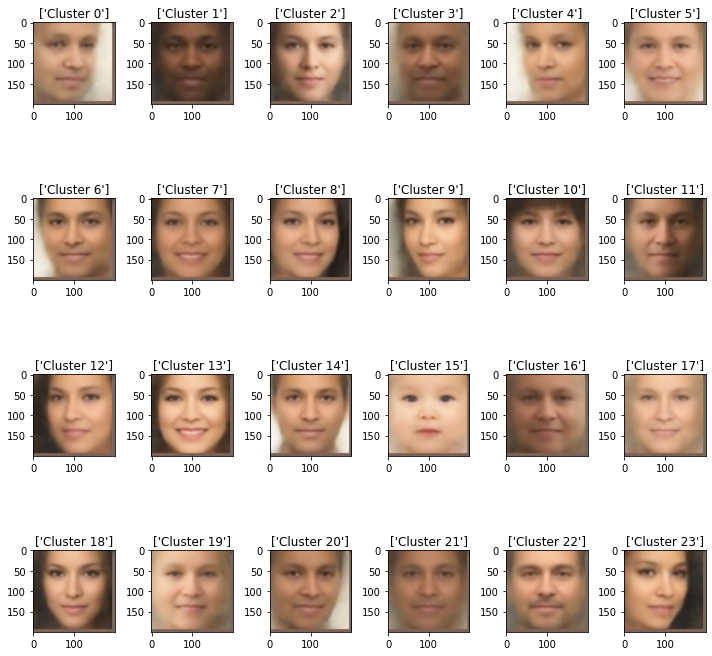

In [3]:
# kmeans = KMeans(n_clusters=24, random_state = 42)
# labels = kmeans.fit_predict(z)
labels = np.load("labels.npy")
C = np.load("cluster_centers.npy")
df = pd.DataFrame({"age":y[:,0], "gender" : y[:,1], "race" : y[:,2], "cluster":labels})
display(df)

## Visualize cluster centers
# C = kmeans.cluster_centers_ # the cluster means
# resp = kmeans.labels_ # a vector of the cluster number for each observation

gs = gridspec.GridSpec(4, 6)
fig = plt.figure(figsize=(10,10))
for i in range(len(C)):
    ax = fig.add_subplot(gs[i])
    latent = torch.from_numpy(C[i]).unsqueeze(0).to(DEVICE).float()
    c = model.decoder(latent).detach().cpu().squeeze().permute(1, 2, 0).numpy()
    ax.imshow(c)
    ax.set_title(['Cluster %d' %i])
    ax.set_aspect('equal', adjustable='box')

fig.tight_layout()
plt.show()


## Age distribution

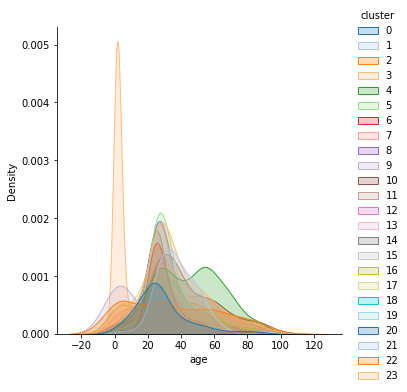

In [7]:
sns.displot(df, x ="age",hue="cluster",kind="kde", fill=True,palette=sns.color_palette("tab20",24))

In [39]:
df.groupby("cluster").median().sort_values("age")

,age,gender,race
cluster,,,
15,1.0,0.0,2.0
9,25.0,1.0,2.0
23,26.0,1.0,1.0
18,26.0,1.0,1.0
10,26.0,1.0,2.0
12,27.0,1.0,1.0
13,27.0,1.0,0.0
2,28.0,0.0,0.0
4,28.0,1.0,1.0


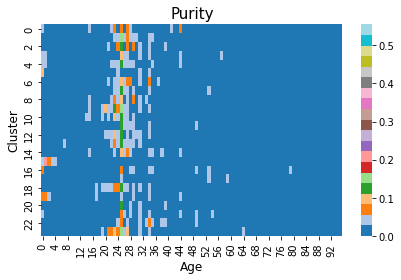

In [40]:
m = metrics.cluster.contingency_matrix(df.age, df.cluster)
purity = m/m.sum(axis=0,keepdims=True)


ax = sns.heatmap(purity.T, cmap="tab20", vmin = 0, vmax = np.max(purity))
ax.set_title("Purity", fontsize=15)
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Cluster", fontsize = 12)

plt.tight_layout()
plt.savefig("../illustrations/age_purity.pdf")

Seems clusters are either dominated by babys or people of age 20-30.

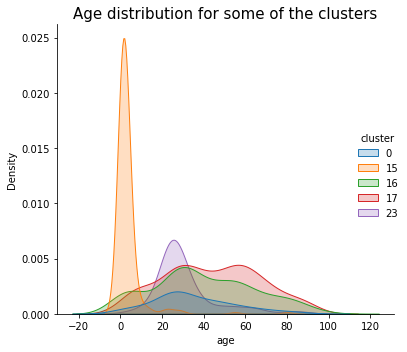

In [41]:
interesting_clusters = [0, 15, 16,17, 23]

# all_ = df.copy()
# all_["cluster"] = 100
# plot_df = pd.concat([df.loc[df.cluster.isin(interesting_clusters)], all_])
# sns.displot(plot_df, x ="age",hue="cluster",kind="kde", fill=True,palette=sns.color_palette("tab20",len(interesting_clusters)+1))

# fig, ax = plt.subplots()
# ax = sns.distplot(df, x ="age", kde = True, fill=True)
sns.displot(
    df[df["cluster"].isin(interesting_clusters)], 
    x ="age",
    hue="cluster",
    kind="kde", 
    fill=True,
    palette=sns.color_palette("tab10",len(interesting_clusters))
)
plt.title("Age distribution for some of the clusters", fontsize=15)

plt.tight_layout()
plt.savefig("../illustrations/age_distribution.pdf")

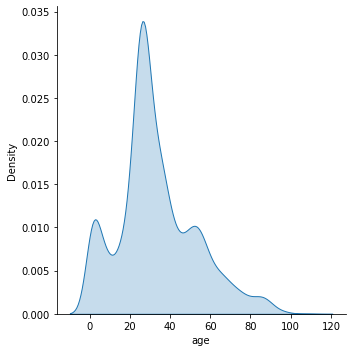

In [74]:
sns.displot(
    df, 
    x ="age",
    kind="kde", 
    fill=True
)

## Gender distribution

C:\Users\lukas\AppData\Local\Temp\ipykernel_18904\1227961552.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["","Men","Women"])


Text(0.5, 1.0, 'Within cluster gender distribution')

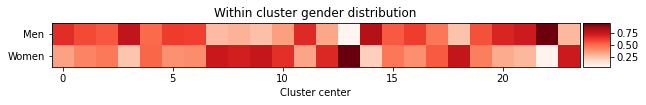

In [4]:
m = metrics.cluster.contingency_matrix(y[:,1], labels)

fig, ax = plt.subplots(figsize=(10,15))
purity = m/m.sum(axis=0,keepdims=True)
im = ax.imshow(purity,cmap="Reds")


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax)

ax.set_xlabel("Cluster center")
ax.set_yticklabels(["","Men","Women"])
ax.set_title("Within cluster gender distribution")




### Bar plot

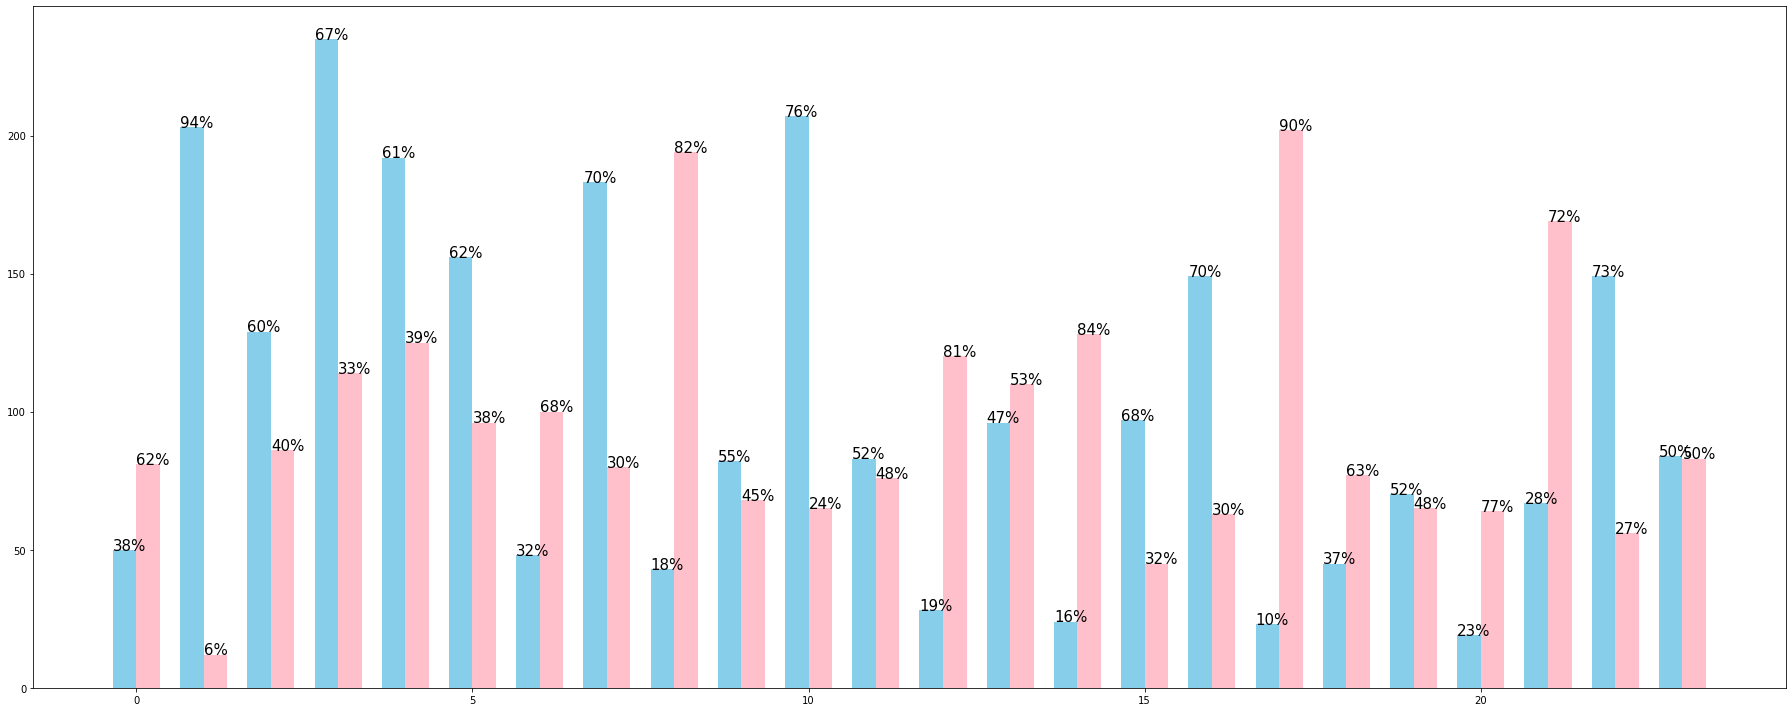

In [137]:
l_men, counts_men = np.unique(df[df["gender"] == 0]["cluster"], return_counts = True)
l_women, counts_women = np.unique(df[df["gender"] == 1]["cluster"], return_counts = True)

fig, ax = plt.subplots(figsize = (25,10))

# ax.set_xticks([i*5 for i in range(24)])
width = .35
ax.bar(l_men-width/2, counts_men, width = width, color = "skyblue")
ax.bar(l_women+width/2, counts_women, width = width, color = "pink")
for i in range(24):
    ax.text(l_men[i]-width, counts_men[i], s =str(int((purity[0][i]*100).round())) + "%", fontdict={"fontsize" : 15})
    ax.text(l_women[i], counts_women[i], s =str(int((purity[1][i]*100).round())) + "%", fontdict={"fontsize" : 15})

# ax.set_fc()
fig.tight_layout()

### Pie chart

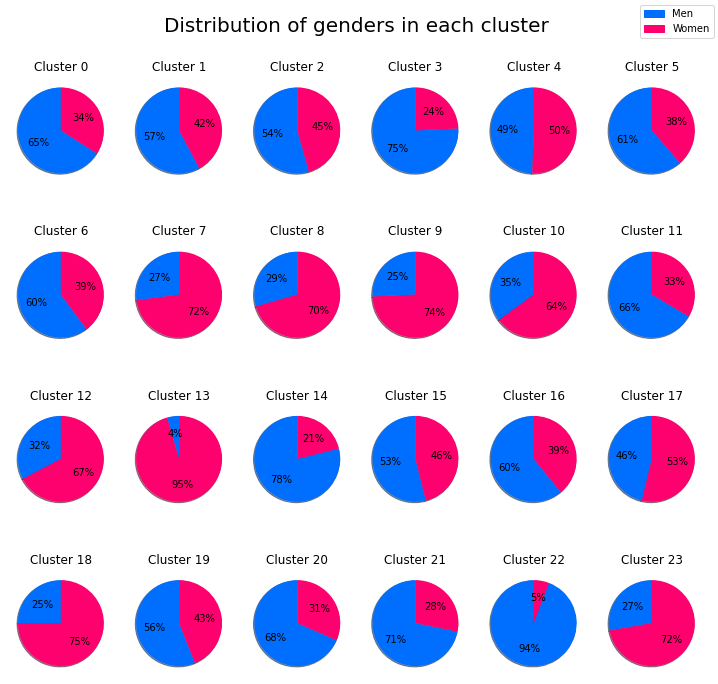

In [5]:


fig, axs = plt.subplots(4, 6, figsize = (10,10))
fig.suptitle("Distribution of genders in each cluster", fontsize = 20)

# ax.scatter(range(24), pct[0])
for i in range(24):
    ax = axs[i//6, i%6]
    ax.pie(purity[:,i], autopct='%.d%%', shadow=True, startangle=90, colors=["#006FFF", "#FF006F"])#, labels=["Men", "women"])
    ax.set_title("Cluster " + str(i))

fig.legend(handles = [
    mpatches.Patch(color='#006FFF', label='Men'),
    mpatches.Patch(color='#FF006F', label='Women')
])
fig.tight_layout()

plt.savefig("../illustrations/gender_cluster_piedist.pdf")

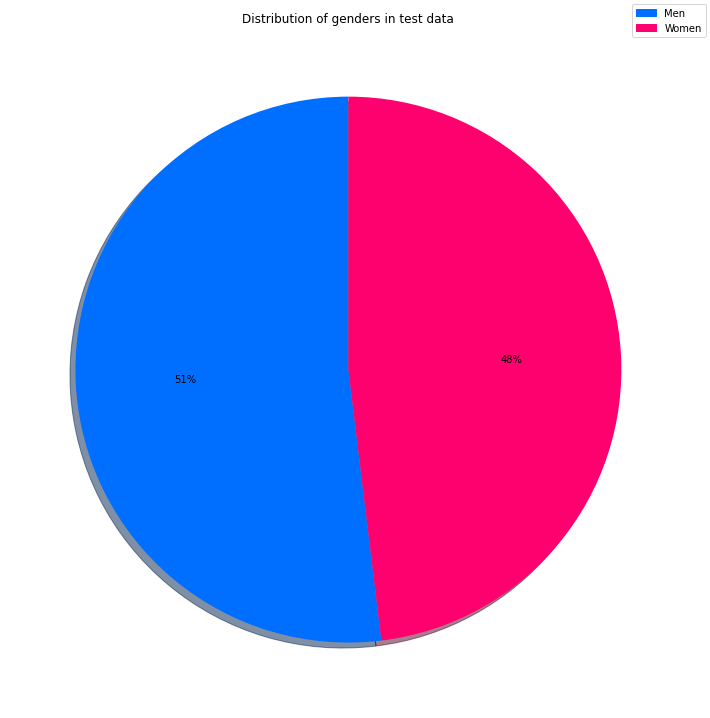

In [6]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.pie(np.unique(df["gender"], return_counts=True)[1], shadow=True, startangle=90, colors=["#006FFF", "#FF006F"], autopct='%.d%%')
ax.set_title("Distribution of genders in test data")
fig.legend(handles = [
    mpatches.Patch(color='#006FFF', label='Men'),
    mpatches.Patch(color='#FF006F', label='Women')
])

fig.tight_layout()

plt.savefig("../illustrations/gender_testset_piedist.pdf")

## Race distribution

C:\Users\lukas\AppData\Local\Temp\ipykernel_18904\2788664773.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(["","white", "black", "asian", "indian", "others"])


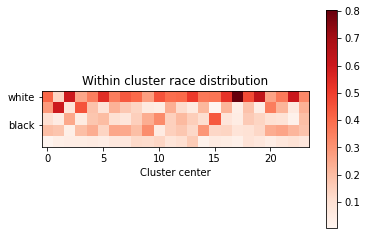

In [8]:
m = metrics.cluster.contingency_matrix(y[:,2], labels)
purity = m/m.sum(axis=0,keepdims=True)
plt.imshow(purity,cmap="Reds")
plt.colorbar()
plt.xlabel("Cluster center")
plt.gca().set_yticklabels(["","white", "black", "asian", "indian", "others"])
plt.title("Within cluster race distribution")

race_dict = {0:"white", 1:"black", 2:"asian", 3:"indian", 4:"others"}

### Pie chart

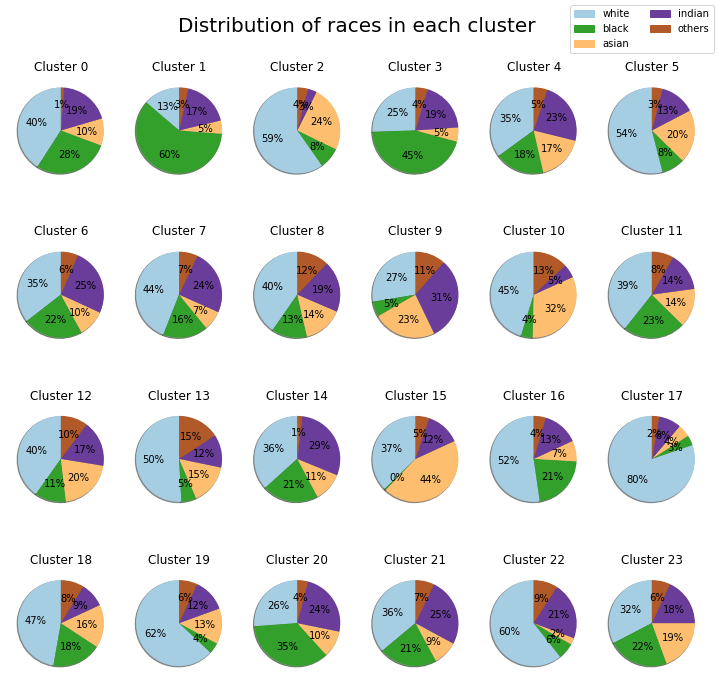

In [9]:
fig, axs = plt.subplots(4, 6, figsize = (10,10))
fig.suptitle("Distribution of races in each cluster", fontsize = 20)

colors = [plt.get_cmap("Paired")(i/4) for i in range(5)]

# ax.scatter(range(24), pct[0])
for i in range(24):
    ax = axs[i//6, i%6]
    ax.pie(purity[:,i], autopct='%.d%%', shadow=True, startangle=90, colors = colors)#, labels=["Men", "women"])
    ax.set_title("Cluster " + str(i))

ls = []
fig.legend(handles = [mpatches.Patch(color=colors[i], label=list(race_dict.values())[i]) for i in range(5)], ncol = 2)
fig.tight_layout()

plt.savefig("../illustrations/race_cluster_piedist.pdf")

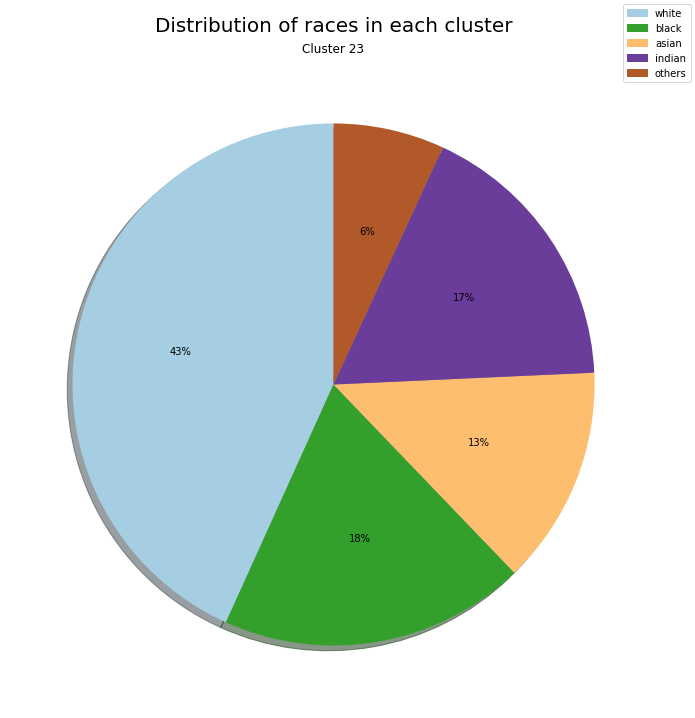

In [168]:
fig, ax = plt.subplots(figsize = (10,10))
fig.suptitle("Distribution of races in test data", fontsize = 20)

colors = [plt.get_cmap("Paired")(i/4) for i in range(5)]

ax.pie(np.unique(df["race"], return_counts=True)[1], autopct='%.d%%', shadow=True, startangle=90, colors = colors)#, labels=["Men", "women"])
ax.set_title("Cluster " + str(i))

ls = []
fig.legend(handles = [mpatches.Patch(color=colors[i], label=list(race_dict.values())[i]) for i in range(5)])
fig.tight_layout()